This notebook will be using the MLEnd London sounds dataset, to build a machine learning pipeline that takes an audio segment as an input and predicts which area the audio segment was recorded in.

In [ ]:
# loading the necessary libraries for the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import librosa
import zipfile
import IPython.display as ipd
from tqdm import tqdm
!pip install imbalanced-learn

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
%matplotlib inline

## Project Formulation
This project will be an end to end machine learning project which will be applying machine learning algorithms to classify audio signals by area recorded in. It will also look at the specific area [campus], and will be predicting which [spot] it is being recorded in. This is because the audio data for the area campus far supersedes the other areas. This means it can be used for classification purposes as it is large enough. Both of these will be multiclass classification problems.
Therefore, the organisation of this notebook will be as follows:

**Part 1: Multi-class classification of audio**
* output: which area this was recorded in?
   - using full dataset

**Part 2: Multi-class classification of audio**
* output: which campus spot was this recorded in?
   - using only data that corresponds to campus area

**Part 3: Extension on basic notebook**
* output: is this recording indoors or outdoors (in the campus area)?
   - using only data that corresponds to campus area

## Machine Learning Pipeline
The input for this pipeline will be the audio segments from the MLEnd London sounds dataset (specifically the features extracted).

**Part 1**: output will be which of the six areas this audio data is recorded in

**Part 2**: output will be which of the six campus spots this audio data is recorded in

**Part 3**: output will be whether the recording is outdoors or indoors but only looking at the campus data

## Transformation Stage
Since audio files are complex data types (mostly time series or discrete signals) , a transformation stage is needed to make sense of the data. The MLEnd London sounds dataset consists of a collection of samples that are described by five attributes. These are: audio, area, spot, indoor/outdoor label, and the participant ID. We need to have the data in a dataframe form to be able to apply the machine learning algorithms with more precision, therefore, we need to parse for each file name, and then create a table like structure for the files then put this into a dataframe.

Since audio files have high dimensionality, we need to extract a few features to be able to train the model, and use these features as predictors. The following features will be extracted from the raw data: power, pitch (mean and standard deviation), and fraction of voiced region. Other extra features that may be extracted include: root mean square(rms), Mel-frequency cepstral coefficients(mfcc), zero crossing rate(zcr), spectral centroid(spc), spectral roll-off(spr).

## Modelling
The following machine learning models have been chosen to be implemented to the data:

1. Support-Vector Machines (SVM) : A supervised machine learning algorithm that can be used for classification. The SVM classifier selects the hyper-plane which classifies the classes accurately prior to maximizing the margin between the classes. Tuning/changing the parameter for the SVM model greatly affects and improves the model accuracy and performance. We will be using the kernel RBF when applying the model, but we need to cross-validate its parameters so we avoid over-fitting. SVM is effective in high-dimensional spaces, and also works well when the number of dimensions is greater than the umber of samples, however, it does not perform well with a large data set.


2. Random Forest Classifier: It is a tree based algorithm, and is also a supervised machine learning algorithm. It works well with classification problems, and requires less data cleaning however, it does have a problem with over-fitting. But this problem can be overcome by pruning and setting constraints on the model parameters. It also uses two methods to ensure that the correlation between the models is low, the first is bagging and the second is feature randomness. The features we select and the hyper-parameters affects the correlation between the decision trees, and thus affects the performance of the model.


3. Ada Boost Classifier: The adabost classifier uses boosting which is a general ensemble method for creating strong classifiers from a number of weak classifiers. It was developed for binary classification, and so this could perform well for our binary classification.


4. Logistic Regression: logistic regression is a classification technique, which uses a logistic function to model the dependent variable, and it can only be used on binary classification.  


5. Decision Tree Classifier: the decision tree classifier builds a model by creating a decision tree. This means like the random forest classifier it is also a tree based algorithm. However, decision trees are prone to overfitting, this could cause an issue in interpretability.


6. K-Nearest Neighbours (kNN): This is a non-parametric, supervised machine learning algorithm. It uses proximity as a basis for making classifications or predictions. However, even though this algorithm is versatile and simple to implement, it does get significantly slower the higher the number of predictors are.

7. Multi-layer Perceptron (MLP) classifier: This model optimizes the log-loss function, it relies on an underlying neural network to perform classifications.

After applying these models, we will assess their efficacy and accuracy in predicting whether an audio file has been recorded indoors or outdoors/which area/which spot. These models were chosen because they are supervised learning models that are suitable for classification purposes and they can be applied to labeled data.  

## Methodology
After the data has been cleaned and preprocessed, we will explore and visualise the data. This is followed by feature extraction and then training and validating the models which is splitting the dataset into training, validation and testing files. The models will initially be applied to the training data, then the performance of the model will be assessed through using the validation data. The training and validation accuracy will be obtained for all models and then compared to choose the best performing model on our data and problem. A boxplot will be used as well to assess and compare model performance.

## Dataset
The data that will be used is the MLEnd London sounds dataset, this will be loaded below.

In [ ]:
# loading the data
data_path = 'MLEnd_DataALL/*.wav'
MLEnd_data = glob.glob(data_path)

len(MLEnd_data)

2496

As we can see the length of the file is 2496, this corresponds to the number of samples/items in the dataset. It is not 2500 as some samples were corrupt/had no audio and were removed.

In [ ]:
# loading the dataframe for the labels
MLEnd_df = pd.read_csv('MLEndLS.csv').set_index('file_id')
MLEnd_df = MLEnd_df.drop('0762.wav')
MLEnd_df = MLEnd_df.drop('2206.wav')
MLEnd_df = MLEnd_df.drop('0170.wav')
MLEnd_df = MLEnd_df.drop('0033.wav')
MLEnd_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


Each name of the wav files correspond to one of the file_id entries in the MLEnd_df dataframe. The corrupt/empty audio files were subsequently removed from the dataframe as well, the process of finding these corrupt files was explained in the 'basic' Jupyter notebook file.

### Exploring and visualising the data

In [ ]:
# counts per area
MLEnd_df['area'].value_counts()

campus        822
westend       666
british       402
Euston        234
southbank     229
kensington    143
Name: area, dtype: int64

We can see that the [campus] area has the most counts and has over 800 audio files which correspond to that area alone, this is enough to use for classification purposes.
The challenge with this problem is that the areas are all not balanced, and this could negatively impact the performance of the classifiers. This imbalance is due to bias sampling, as the data collection was made by students, most of whom either live on or near campus or attend classes daily and would thus choose to record the audio on campus as it is easier and closer. The further away the area is from campus the less data there is on it as we can see from the [Kensington] area.

<AxesSubplot: >

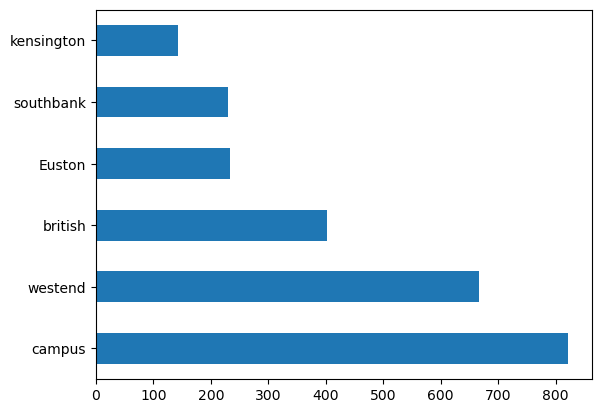

In [ ]:
# plot of value counts of areas
MLEnd_df['area'].value_counts().plot(kind='barh')

Looking at the campus area specifically:

In [ ]:
# creating new dataframe only for the campus area
campus_df = MLEnd_df.loc[(MLEnd_df['area']=='campus') & (MLEnd_df['spot'])]
campus_df

,area,spot,in_out,Participant
file_id,,,,
0003.wav,campus,square,outdoor,S18
0005.wav,campus,square,outdoor,S176
0008.wav,campus,canal,outdoor,S20
0014.wav,campus,square,outdoor,S145
0015.wav,campus,reception,indoor,S99
...,...,...,...,...
2484.wav,campus,square,outdoor,S56
2488.wav,campus,ground,indoor,S79
2493.wav,campus,library,outdoor,S61


In [ ]:
# loading the campus audio data
data_path = 'MLEnd_campus_data/*.wav'
campus_data = glob.glob(data_path)

len(campus_data)

822

In [ ]:
campus_df['spot'].value_counts()

square       141
ground       139
canal        137
reception    136
curve        136
library      133
Name: spot, dtype: int64

The campus data is more balanced and this will be beneficial in the classification models as they work better on balanced datasets.

<AxesSubplot: >

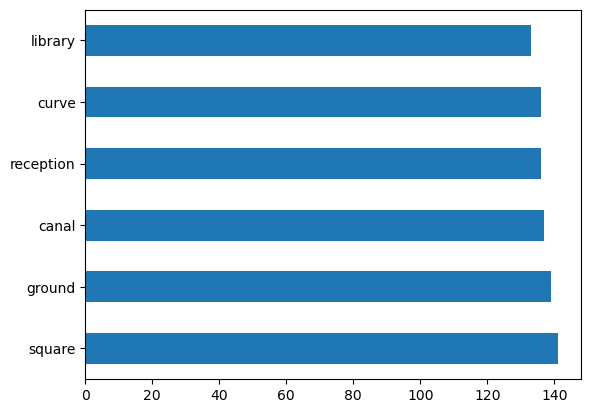

In [ ]:
campus_df['spot'].value_counts().plot(kind='barh')

In [ ]:
# shows contents of folder that stores audio files
for file in campus_data:
    file.split('/')[-1]

In [ ]:
# shows contents of folder that stores audio files
for file in MLEnd_data:
    file.split('/')[-1]

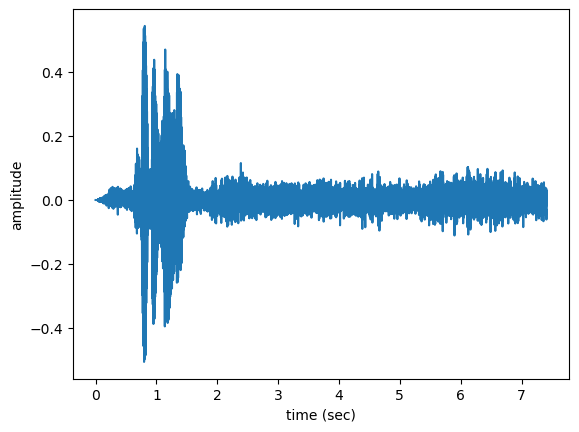

In [ ]:
# plot of one audio file
n = 0
fs = None # sampling frequency
x, fs = librosa.load(MLEnd_data[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')

# listening to the same audio file that is plotted
display(ipd.Audio(MLEnd_data[n]))

In [ ]:
n = 0
x, fs = librosa.load(MLEnd_data[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 326781 samples


Preprocessing and cleaning of the data has already been performed in the 'basic' Jupyter notebook and so will not be repeated here.

Now we will perform a feature extraction on the dataset as a whole and then also for the campus data specifically.

In [ ]:
# function to extract the pitch from audio files
def getPitch(x, fs, winLen = 0.02):
    #winLen = 0.02
    p = winLen * fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

The next function will create a numpy array by using the audio files we have with the csv dataframe. This array will contain four audio features that will be used as predictors (X), and the (y) label will be corresponding to:

**In part 1(areas):** 0:kensington, 1:southbank, 2:euston, 3:british, 4:westend, 5:campus.

**In part 2(campus spots):** 0:square, 1:library, 2:canal, 3:reception, 4:ground, 5:curve.

**In part 3(campus area):** 0: outdoors, 1: indoors.

As we can see parts 1 and 2 will be multi-class and part 3 will be binary.

**PART 1**

In [ ]:
# function that creates a numpy array from audio file and csv dataframe created
# PART 1
def getXy1(files,labels_file, scale_audio=False, onlySingleDigit=False):

    X, y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        if labels_file.loc[fileID]['area']=='kensington':
            yi=0
        elif labels_file.loc[fileID]['area']=='southbank':
            yi=1
        elif labels_file.loc[fileID]['area']=='Euston':
            yi=2
        elif labels_file.loc[fileID]['area']=='british':
            yi=3
        elif labels_file.loc[fileID]['area']=='westend':
            yi=4
        else:
            yi=5 #campus

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file, sr = fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
        mfccs = np.mean(librosa.feature.mfcc(y=x, sr=fs))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=x))
        spc = np.mean(librosa.feature.spectral_centroid(y=x, sr=fs))
        spr = np.mean(librosa.feature.spectral_rolloff(y=x, sr=fs))
        rms = np.mean(librosa.feature.rms(y=x))


        xi = [power,pitch_mean,pitch_std,voiced_fr,mfccs,zcr,spc,spr,rms]
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

**PART 2**

In [ ]:
# function that creates a numpy array from audio file and csv dataframe created
# PART 2
def getXy2(files,labels_file, scale_audio=False, onlySingleDigit=False):

    X, y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        if labels_file.loc[fileID]['spot']=='square':
            yi=0
        elif labels_file.loc[fileID]['spot']=='library':
            yi=1
        elif labels_file.loc[fileID]['spot']=='canal':
            yi=2
        elif labels_file.loc[fileID]['spot']=='reception':
            yi=3
        elif labels_file.loc[fileID]['spot']=='ground':
            yi=4
        else:
            yi=5 #curve

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file, sr = fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
        mfccs = np.mean(librosa.feature.mfcc(y=x, sr=fs))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=x))
        spc = np.mean(librosa.feature.spectral_centroid(y=x, sr=fs))
        spr = np.mean(librosa.feature.spectral_rolloff(y=x, sr=fs))
        rms = np.mean(librosa.feature.rms(y=x))

        xi = [power,pitch_mean,pitch_std,voiced_fr,mfccs,zcr,spc,spr,rms]
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

**PART 3**

In [ ]:
# function that creates a numpy array from audio file and csv dataframe created
def getXy3(files,labels_file, scale_audio=False, onlySingleDigit=False):

    X, y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        yi = labels_file.loc[fileID]['in_out']=='indoor'

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file, sr = fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)


        xi = [power,pitch_mean,pitch_std,voiced_fr]
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

### PART 1: Classification of Area

In [ ]:
# applying the function to our data

X,y = getXy1(MLEnd_data, labels_file = MLEnd_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2496/2496 [1:23:53<00:00,  2.02s/it]


In [ ]:
# to check the shape of the X and y
print('The shape of X is', X.shape)
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2496, 9)
The shape of y is (2496,)
The labels vector is [5 4 4 ... 3 5 1]


### PART 2: Classification of Campus Spots

In [ ]:
# applying the function to our data

X2,y2 = getXy2(campus_data, labels_file = campus_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 822/822 [29:24<00:00,  2.15s/it]  


In [ ]:
# to check the shape of the X and y
print('The shape of X is', X2.shape)
print('The shape of y is', y2.shape)
print('The labels vector is', y2)

The shape of X is (822, 9)
The shape of y is (822,)
The labels vector is [1 4 3 3 3 5 3 5 4 2 2 4 0 3 4 0 4 1 3 1 5 1 0 1 4 5 0 4 4 2 2 5 5 3 2 0 5
 4 3 0 0 5 5 4 3 0 1 0 0 1 5 1 0 3 1 3 0 2 4 1 4 0 5 5 3 0 4 5 4 0 2 2 2 2
 2 1 0 4 3 2 2 3 1 5 1 0 3 4 2 0 2 5 0 5 1 5 3 1 4 1 3 1 4 5 0 4 5 2 3 4 1
 0 4 2 0 0 2 2 5 2 5 2 0 0 1 4 3 3 2 5 1 3 1 2 0 5 5 0 2 3 0 4 3 5 3 1 2 1
 5 2 0 0 3 0 2 2 1 0 2 5 5 2 2 1 4 4 2 4 3 1 2 0 5 3 5 2 0 2 2 3 5 3 1 4 4
 4 1 2 5 5 2 5 3 1 0 5 3 1 1 5 0 0 0 0 4 0 2 5 3 4 5 4 0 0 2 1 3 0 1 2 0 4
 3 5 1 1 2 0 0 1 5 4 3 4 0 2 1 5 1 3 1 5 4 2 1 3 4 1 5 0 2 4 2 0 3 0 5 0 3
 0 1 2 3 5 0 1 5 1 0 3 4 3 0 2 2 4 2 5 0 4 3 3 5 1 2 4 5 4 3 2 2 5 4 0 5 0
 5 2 1 3 1 3 3 5 1 3 1 3 1 1 1 4 4 4 2 3 1 2 4 4 5 4 5 0 3 1 2 2 3 0 3 3 1
 3 0 1 3 4 3 2 4 4 4 0 1 2 4 4 4 0 2 2 4 5 1 4 2 3 0 5 3 0 0 3 5 3 4 2 0 0
 4 0 1 1 2 2 2 1 1 1 1 5 0 3 4 3 4 5 5 4 0 3 4 5 1 0 5 4 2 3 2 0 5 0 1 1 0
 4 2 5 4 0 2 2 2 5 3 1 1 3 0 5 3 2 3 4 4 1 5 4 2 1 4 1 0 4 1 2 1 1 4 5 3 0
 1 3 4 5 2 2 1 1 5 5 4 0 5 

### PART 3: Classification of Campus Area (indoor or outdoor)

In [ ]:
X3,y3 = getXy3(campus_data, labels_file = campus_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 822/822 [16:04<00:00,  1.17s/it]  


In [ ]:
# to check the shape of the X and y
print('The shape of X is', X3.shape)
print('The shape of y is', y3.shape)
print('The labels vector is', y3)

The shape of X is (822, 4)
The shape of y is (822,)
The labels vector is [False  True  True  True  True  True  True  True  True False False  True
 False  True  True False  True False  True False  True False False False
  True  True False  True  True False False  True  True  True False False
  True  True  True False False  True  True  True  True False False False
 False False  True False False  True False  True False False  True False
  True False  True  True  True False  True  True  True False False False
 False False False False False  True  True False False  True False  True
 False False  True  True False False False  True False  True False  True
  True False  True False  True False  True  True False  True  True False
  True  True False False  True False False False False False  True False
  True False False False False  True  True  True False  True False  True
 False False False  True  True False False  True False  True  True  True
  True False False False  True False False False  T

In [ ]:
# checking to see if the dataset is balanced
print(' The number of indoor recordings is ', np.count_nonzero(y3))
print(' The number of outdoor recordings is ', y3.size - np.count_nonzero(y3))

 The number of indoor recordings is  411
 The number of outdoor recordings is  411


As we can see the number of indoor and outdoor recordings in the campus area dataset is identical, this means the models have a higher chance of achieving greater accuracies due to it being balanced. We can see that the dataset is balanced and this will bode well for the classifiers.

## Results
This section will explore the different models specified above.



### PART 1: Classification of Area

#### Model 1: Support-Vector Machines (SVM)

In [ ]:
# splitting dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=321)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# applying the SVM model
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.4127074985689754
Validation  Accuracy 0.3885180240320427
The support vectors are (1673, 9)


The SVM model gives us a training accuracy of 0.42 and a validation accuracy of 0.39. This is not a particularly good score. To check if there are better parameters we could have chosen, we will apply a grid search for the SVM model. This will give us the best estimators for our current model.

In [ ]:
# grid search for SVM
param_grid = {
    'C': [0.1,1, 10],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.2s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [ ]:
# finding the best estimator
print(grid.best_estimator_)

SVC(C=1, gamma=0.1)


After applying the grid search method to find the best hyperparameters we can now tune our model to reflect these and see if there are any improvements in accuracy.

In [ ]:
# applying the SVM model with new parameters
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1, gamma=0.1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.406983400114482
Validation  Accuracy 0.38451268357810414
The support vectors are (1666, 9)


There are no notable improvements after applying the tuned parameters.

We can see that applying the model directly on the imbalanced data did not give a satisfactory score for accuracy. Therefore, we will try to process the data to solve the issue of the imbalance. Firstly, we will try to randomly oversample the minority class, and apply the model again. Then we will randomly undersample the majority class and compare both accuracies.


In [ ]:
print("Before over-sampling: ",Counter(y_train))
SMOTE = SMOTE()

# fit and apply the transformation
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

print("After over-sampling: ",Counter(y_train_SMOTE))

Before over-sampling:  Counter({5: 569, 4: 462, 3: 298, 1: 161, 2: 158, 0: 99})
After over-sampling:  Counter({3: 569, 2: 569, 0: 569, 5: 569, 4: 569, 1: 569})


In [ ]:
# applying the SVM model on oversampled data
mean = X_train_SMOTE.mean(0)
sd =  X_train_SMOTE.std(0)

X_train_SMOTE = (X_train_SMOTE-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1, gamma='scale', random_state=42)
model.fit(X_train_SMOTE,y_train_SMOTE)

yt_p = model.predict(X_train_SMOTE)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train_SMOTE))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.4715875805506737
Validation  Accuracy 0.2696929238985314
The support vectors are (3210, 9)


As we can see the validation accuracy has actually decreased (from 0.39 to 0.27) after applying the over-sampling technique, however, the training accuracy has increased slightly (from 0.42 to 0.47).

In [ ]:
print("Before under-sampling: ", Counter(y_train))

undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transformation
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print("After under-sampling: ", Counter(y_train_under))

Before under-sampling:  Counter({5: 569, 4: 462, 3: 298, 1: 161, 2: 158, 0: 99})
After under-sampling:  Counter({4: 462, 3: 298, 1: 161, 2: 158, 0: 99, 5: 99})


In [ ]:
# applying the SVM model on undersampled data
mean = X_train_under.mean(0)
sd =  X_train_under.std(0)

X_train_under = (X_train_under-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1, gamma='scale', random_state=42)
model.fit(X_train_under,y_train_under)

yt_p = model.predict(X_train_under)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train_under))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.4197337509788567
Validation  Accuracy 0.2803738317757009
The support vectors are (1230, 9)


Compared to the over-sampling, the under-sampling has achieved a slightly higher validation score (from 0.26 to 0.28), and the training accuracy has decreased slightly (from 0.47 to 0.42).

After applying both techniques we can see no notable improvement in classification accuracy of the SVM models, as the SVM model applied to the data as is achieves a better result. We will move on to try other classification models.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd
Models = [
                         RandomForestClassifier(),
                         AdaBoostClassifier(),
                         LogisticRegression(),
                         DecisionTreeClassifier(),
                         KNeighborsClassifier(),
                         SVC(kernel='rbf'),
                         MLPClassifier(max_iter=5000)
]
accuracy_scores = []
for model in Models:
    model.fit(X_train,y_train)
    score = model.score(X_val,y_val)
    yt_p = model.predict(X_train)
    model_name = type(model).__name__
    accuracy_scores.append((model_name,(f'{100*score:.2f}%'), np.mean(yt_p==y_train)))
accuracy_df = pd.DataFrame(accuracy_scores,columns=['Classification Model','Validation Accuracy', 'Training Accuracy'])
accuracy_df.sort_values(by = 'Validation Accuracy',axis = 0, ascending = True)

,Classification Model,Validation Accuracy,Training Accuracy
3,DecisionTreeClassifier,27.10%,1.000000
4,KNeighborsClassifier,31.91%,0.539210
1,AdaBoostClassifier,35.25%,0.393246
2,LogisticRegression,37.92%,0.376646
5,SVC,38.45%,0.412707
6,MLPClassifier,39.25%,0.569548
0,RandomForestClassifier,39.52%,1.000000


The best model with the highest validation accuracy is is the random forest classifier model, which does not necessarily mean it is a good model as it still only has 39.5% accuracy. However, the model with the highest training accuracy are the random forest classifier and decision tree classifier followed by the k neighbours classifier. Some of these classifiers are developed to be used only on binary data and so it was expected that they would not work as well as other classifiers, for example, the Adaboost classifier and the logistic regression models.

### PART 2: Classification of Campus Spots

#### Model 1: Support-Vector Machines (SVM)

In [ ]:
# splitting dataset into training and validation sets

X2_train, X2_val, y2_train, y2_val = train_test_split(X2,y2,test_size=0.3, random_state=321)
X2_train.shape, X2_val.shape, y2_train.shape, y2_val.shape

# applying the SVM model
mean = X2_train.mean(0)
sd =  X2_train.std(0)

X2_train = (X2_train-mean)/sd
X2_val  = (X2_val-mean)/sd

model  = svm.SVC(C=1, gamma='scale', random_state=42)
model.fit(X2_train,y2_train)

yt_p = model.predict(X2_train)
yv_p = model.predict(X2_val)

print('Training Accuracy', np.mean(yt_p==y2_train))
print('Validation  Accuracy', np.mean(yv_p==y2_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5756521739130435
Validation  Accuracy 0.41295546558704455
The support vectors are (545, 9)


Since the data for the campus area is more much balanced, this is reflected in the accuracy obtained from the models. The training accuracy is 0.58, while the validation accuracy is 0.41. We will apply the grid search method again to obtain the best parameters for the model.

In [ ]:
# grid search for SVM
param_grid = {
    'C': [0.1,1, 10],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X2_train,y2_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [ ]:
# finding the best estimator
print(grid.best_estimator_)

SVC(C=10, gamma=0.1)


In [ ]:
# applying the SVM model with new parameters
mean = X2_train.mean(0)
sd =  X2_train.std(0)

X2_train = (X2_train-mean)/sd
X2_val  = (X2_val-mean)/sd

model  = svm.SVC(C=10, gamma=0.1)
model.fit(X2_train,y2_train)

yt_p = model.predict(X2_train)
yv_p = model.predict(X2_val)

print('Training Accuracy', np.mean(yt_p==y2_train))
print('Validation  Accuracy', np.mean(yv_p==y2_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.7095652173913043
Validation  Accuracy 0.4089068825910931
The support vectors are (511, 9)


As we can see the model has improved its training accuracy which is now 0.71, while the validation accuracy has stayed around the same at 0.41.

## Comparison of all models
* Model 2: Random Forest Classifier
* Model 3: Ada Boost Classifier
* Model 4: Logistic Regression
* Model 5: Decision Tree Classifier
* Model 6: K-Nearest Neighbours (kNN)
* Model 7: MLP Classifier

We will now compare all models, this is to reduce the code required instead of individually testing each model, we will combine it and run it through once to get the accuracy for the training and validation sets for all models. The datasets will be normalised before applying the models.

In [ ]:
mean = X2_train.mean(0)
sd =  X2_train.std(0)
X2_train = (X2_train-mean)/sd
X2_val  = (X2_val-mean)/sd
Models = [
                         RandomForestClassifier(),
                         AdaBoostClassifier(),
                         LogisticRegression(),
                         DecisionTreeClassifier(),
                         KNeighborsClassifier(),
                         SVC(kernel='rbf'),
                         MLPClassifier(max_iter=50000)
]
accuracy_scores = []
for model in Models:
    model.fit(X2_train,y2_train)
    score = model.score(X2_val,y2_val)
    yt_p = model.predict(X2_train)
    model_name = type(model).__name__
    accuracy_scores.append((model_name,(f'{100*score:.2f}%'), np.mean(yt_p==y2_train)))
accuracy_df = pd.DataFrame(accuracy_scores,columns=['Classification Model','Validation Accuracy', 'Training Accuracy'])
accuracy_df.sort_values(by = 'Validation Accuracy',axis = 0, ascending = True)

,Classification Model,Validation Accuracy,Training Accuracy
3,DecisionTreeClassifier,27.13%,1.000000
4,KNeighborsClassifier,33.20%,0.556522
1,AdaBoostClassifier,34.01%,0.497391
6,MLPClassifier,36.44%,0.996522
0,RandomForestClassifier,38.87%,1.000000
5,SVC,41.30%,0.575652
2,LogisticRegression,43.32%,0.488696


The best performing model is the logistic regression with 43.3% validation accuracy, this result is surprising as logistic regression does not perform well with non-binary values. The models with the highest training accuracy is again the random forest classifier and the decision tree classifier followed closely by the MLP classifier.

All classifiers for both parts did not perform particularly well, and this could be due to the data being imbalanced, not large enough and since it is audio files it could just be that audio is not dependent on neither area nor the filming spots which is to be expected. The audio would also be near impossible to distinguish by sound for area or spots by humans, and therefore, it is immensely more difficult for a model to be able to predict whether an audio is in a particular spot or area. The best a model may perform in these tasks is in my opinion around 50%.
As an extension to the basic notebook,campus area data and dataframe will be used to enhance on the basic Jupyter notebook by only using one area to classify samples as either being indoors or outdoors. This could prove to be a more balanced dataset and therefore provide more accurate predictions.

In [ ]:
# splitting dataset into training and validation sets

X3_train, X3_val, y3_train, y3_val = train_test_split(X3,y3,test_size=0.3, random_state=321)
X3_train.shape, X3_val.shape, y3_train.shape, y3_val.shape

# applying the SVM model
mean = X3_train.mean(0)
sd =  X3_train.std(0)

X3_train = (X3_train-mean)/sd
X3_val  = (X3_val-mean)/sd

model  = svm.SVC(C=1, gamma='scale', random_state=42)
model.fit(X3_train,y3_train)

yt_p = model.predict(X3_train)
yv_p = model.predict(X3_val)

print('Training Accuracy', np.mean(yt_p==y3_train))
print('Validation  Accuracy', np.mean(yv_p==y3_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.6573913043478261
Validation  Accuracy 0.5506072874493927
The support vectors are (479, 4)


As we can see this is a significant improvement on the findings in the 'basic' notebook, and this leads me to believe that separating each area and applying the machine learning algorithms separately to ensure a balanced dataset will allow the classifiers to perform much better. The training and validation accuracy have both increased but the training accuracy has increased much more.
The validation accuracy has increased from 0.54 to 0.55, while the training accuracy has increased from 0.59 to 0.66.
We will check if these results could be compared with other models to check if it has really improved or not.


In [ ]:
mean = X3_train.mean(0)
sd =  X3_train.std(0)
X3_train = (X3_train-mean)/sd
X3_val  = (X3_val-mean)/sd
Models = [
                         RandomForestClassifier(),
                         AdaBoostClassifier(),
                         LogisticRegression(),
                         DecisionTreeClassifier(),
                         KNeighborsClassifier(),
                         SVC(kernel='rbf')

]
accuracy_scores = []
for model in Models:
    model.fit(X3_train,y3_train)
    score = model.score(X3_val,y3_val)
    yt_p = model.predict(X3_train)
    model_name = type(model).__name__
    accuracy_scores.append((model_name,(f'{100*score:.2f}%'), np.mean(yt_p==y3_train)))
accuracy_df = pd.DataFrame(accuracy_scores,columns=['Classification Model','Validation Accuracy', 'Training Accuracy'])
accuracy_df.sort_values(by = 'Validation Accuracy',axis = 0, ascending = True)

,Classification Model,Validation Accuracy,Training Accuracy
5,SVC,55.06%,0.657391
3,DecisionTreeClassifier,56.28%,1.000000
1,AdaBoostClassifier,57.09%,0.718261
2,LogisticRegression,57.89%,0.622609
6,MLPClassifier,58.70%,0.681739
4,KNeighborsClassifier,59.51%,0.685217
0,RandomForestClassifier,61.94%,1.000000


As we can see the random forest classifier is the best classifier with a validation accuracy of 61.95%. These models all performed better than the ones tested in the basic notebook as they had a maximum validation score of 54.8%. And all models performed well (over 0.6) on the training data. And to note, the extracted features have purposefully remained the same between this and the basic notebook to be able to objectively compare the models in part 3 with that of the basic notebook.

## Conclusions

To conclude, the models used provided results that were not completely satisfactory. However, when looking at the validation accuracies in terms of the context it seems the results are not too bad. This is because the problems given in this notebook would be difficult for a human to decipher through audio alone, therefore it is understandable that the accuracies would not be above a certain threshold of accuracy.



### Improvements

Improvements could include:
* utilising more balanced datasets, or applying pre-processing techniques to alter the balance of the datasets so one class does not empower another class.
* other classifying problems could have been implemented if demographic data was available. For example, did more students choose to take the videos on campus because they lived closer or on campus? Or can we classify gender based on audio recordings, as in the beginning we say 'This is London'.
* using more complex models while grid searching all possible combinations for all the models, is both effort and time-consuming but this would have improved the results. As this would have been utilised to choose the best possible model for our problem.
* further research on which models are suitable for which purposes and studying/researching on the characteristics of audio data specifically would have been useful as well to better understand the features extracted and what they represent.
* normalisation of the features to bound them from between -1 to 1, could have improved the efficacy of the models.
* including further features in the model evaluation
* noise reduction techniques could have also been applied to the dataset to improve the model accuracies.